In [1]:
import sounddevice as sd
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy.io.wavfile import write, read
from numpy.fft import fft, ifft
from tqdm import tqdm
import time

In [2]:
def firfilter(sig, fs, low=None, high=None):

    if low is None:
        low = 0
    if high is None:
        high = fs/2
    
    assert(low < high)
    assert(high <= fs/2)
    assert(sig.ndim == 1)
    
    N = sig.size
    f = np.arange(N) * fs / N
    sigfft = fft(sig)
    mask = ((f>=low) & (f<=high)) | ((f>=(fs-high)) & (f<=(fs-low)))
    filtfft = np.zeros_like(sigfft)
    filtfft[mask] = sigfft[mask]
    
    return np.real(ifft(filtfft))

fs = 48000
sd.default.samplerate = fs
sd.default.channels = 1


## Microphone Recording

In [3]:
mic_duration = 10
# sd.play(chirp, fschirp)
samples = sd.rec(int(mic_duration*fs))
for i in tqdm(range(int(mic_duration*10))):
    time.sleep(0.1)
sd.wait()
rxsig = np.squeeze(samples)


100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


In [38]:
sd.play(rxsig, fs)

In [293]:
sd.stop()

## Saving Recording

In [4]:
np.save('probe_test', rxsig)

## Signal Preview

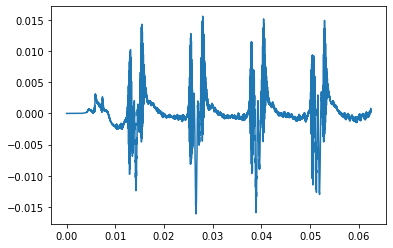

In [383]:
plt.plot(np.arange(3000)/fs, rxsig[:3000])
plt.show()

## Chirps

960 864 9600


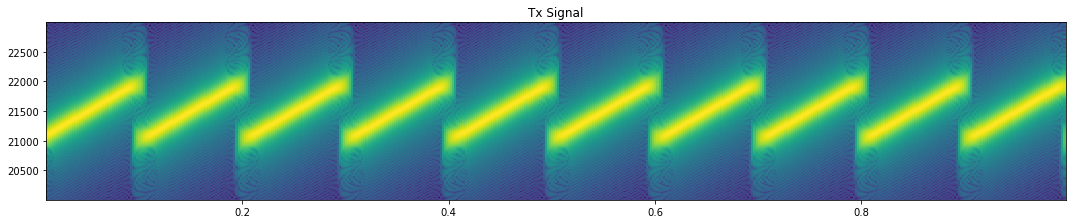

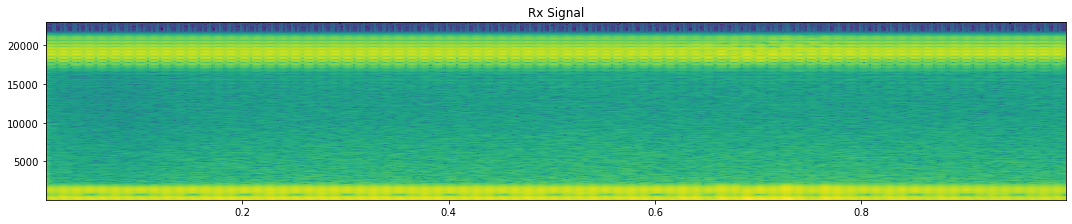

In [384]:
txfs, txsig = read('./audio/chirp.wav')
assert(txfs == fs)
txsig = txsig[:len(rxsig)]
txsig = txsig[:,0] # grab left channel only

nperseg = fs//50
noverlap = int(nperseg*0.9)
nfft = nperseg*10
print(nperseg, noverlap, nfft)
f, t, X = ss.spectrogram(txsig, fs, 'hann', nperseg=nperseg, noverlap=noverlap, nfft=nfft)

fwin = (f > 20e3) & (f < 23e3)
twin = (t > 0) & (t < 1)

plt.figure(figsize=(15,3))
plt.pcolormesh(t[twin], f[fwin], np.log(X[fwin][:,twin]))
plt.tight_layout()
plt.title("Tx Signal")
plt.show()

nperseg = fs//50
noverlap = int(nperseg*0.9)
nfft = nperseg*10
f, t, Y = ss.spectrogram(rxsig, fs, 'hann', nperseg=nperseg, noverlap=noverlap)

fwin = (f > 0e3) & (f < 23e3)
twin = (t > 0) & (t < 1)

plt.figure(figsize=(15,3))
plt.pcolormesh(t[twin], f[fwin], np.log(Y[fwin][:,twin]))
plt.tight_layout()
plt.title("Rx Signal")
plt.show()


In [ ]:
nperseg = fs//50
noverlap = int(nperseg*0.9)
nfft = nperseg*10

z = np.roll(txsig, 4800//4) * rxsig
f, t, Z = ss.spectrogram(z, fs, 'hann', nperseg=nperseg, noverlap=noverlap, nfft=nfft)

fwin = (f > 19e3) & (f < 24e3)
twin = (t > 0) & (t < 10)

plt.figure(figsize=(15,3))
plt.pcolormesh(t[twin], f[fwin], np.log(Z[fwin][:,twin]))
plt.tight_layout()
plt.title("Tx Rx Product")
plt.show()


## Probes

480 432 4800


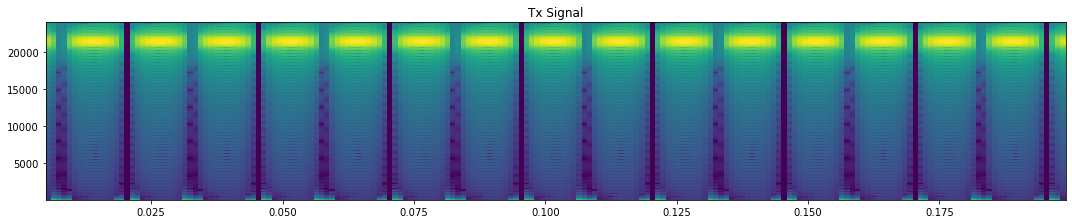

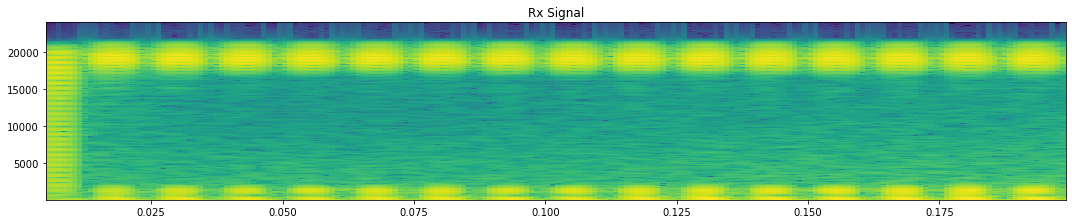

In [5]:
txsig = np.load('probe_tx.npy')

nperseg = fs//100
noverlap = int(nperseg*0.9)
nfft = nperseg*10
print(nperseg, noverlap, nfft)
f, t, X = ss.spectrogram(txsig, fs, 'hann', nperseg=nperseg, noverlap=noverlap, nfft=nfft)

fwin = (f > 0e3) & (f < 28e3)
twin = (t > 0) & (t < 0.2)

plt.figure(figsize=(15,3))
plt.pcolormesh(t[twin], f[fwin], np.log(X[fwin][:,twin]+1e-10))
plt.tight_layout()
plt.title("Tx Signal")
plt.show()

nperseg = fs//100
noverlap = int(nperseg*0.9)
nfft = nperseg*10
f, t, Y = ss.spectrogram(rxsig, fs, 'hann', nperseg=nperseg, noverlap=noverlap)

fwin = (f > 0e3) & (f < 28e3)
twin = (t > 0) & (t < 0.2)

plt.figure(figsize=(15,3))
plt.pcolormesh(t[twin], f[fwin], np.log(Y[fwin][:,twin]))
plt.tight_layout()
plt.title("Rx Signal")
plt.show()


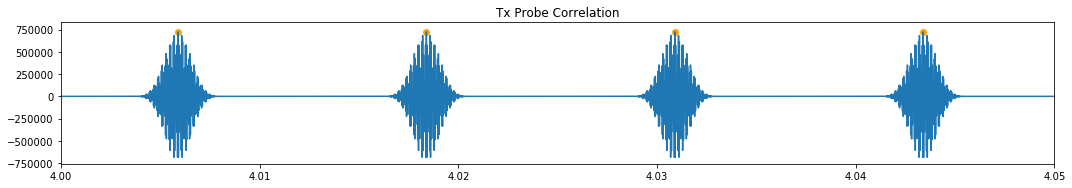

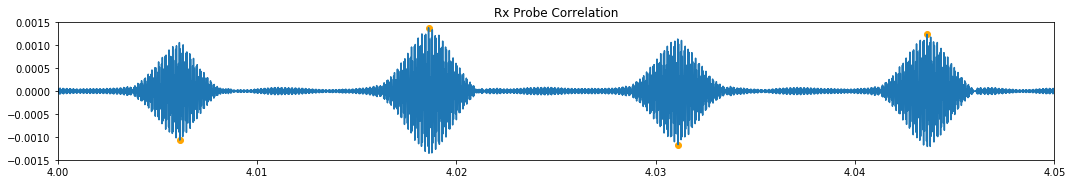

In [38]:
probe = np.load('probe.npy')

txcorr = ss.correlate(txsig, probe, mode='full')
rxcorr = ss.correlate(rxsig, probe, mode='full')

pk_tx, _ = ss.find_peaks(np.abs(txcorr), distance = fs/82)
pk_rx, _ = ss.find_peaks(np.abs(rxcorr), distance = fs/82)
offset = pk_rx[0] - pk_tx[0]
txcorr = np.roll(txcorr, offset)
txcorr = txcorr[:rxcorr.size]

txp, _ = ss.find_peaks(np.abs(txcorr), distance = fs/82)
rxp, _ = ss.find_peaks(np.abs(rxcorr), distance = fs/82)

t = np.arange(txcorr.size) / fs

plt.figure(figsize=(15,2.5))
plt.plot(t, txcorr)
plt.scatter(t[txp], txcorr[txp], c='orange')
plt.xlim(4, 4.05)
# plt.xlim(0.00625, 0.01865)
plt.tight_layout()
plt.title("Tx Probe Correlation")
plt.show()

plt.figure(figsize=(15,2.5))
plt.plot(t, rxcorr)
plt.scatter(t[rxp], rxcorr[rxp], c='orange')
plt.xlim(4, 4.05)
plt.ylim(-0.0015, 0.0015)
# plt.xlim(0.00625, 0.01865)
plt.tight_layout()
plt.title("Rx Probe Correlation")
plt.show()


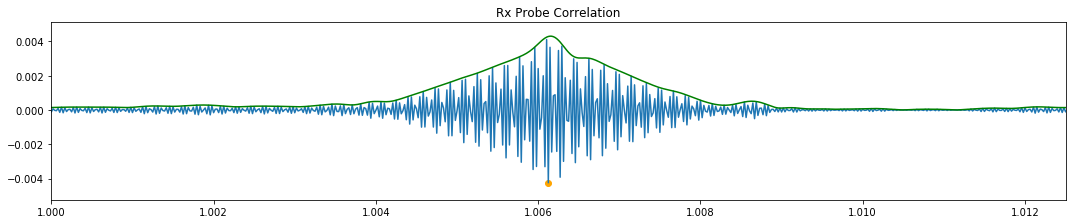

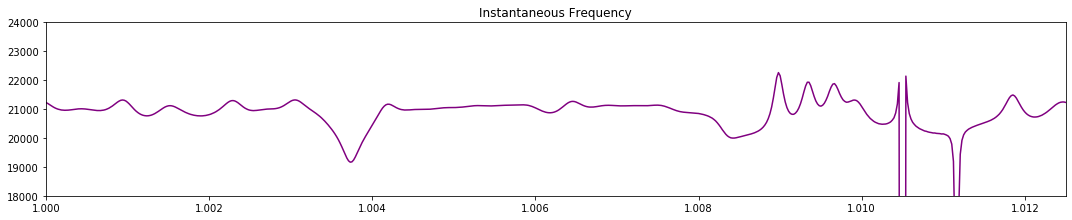

In [48]:
hrx = ss.hilbert(rxcorr)

hmag = np.abs(hrx)
hphase = np.unwrap(np.angle(hrx))
hfreq = np.diff(hphase, prepend=hphase[1]-hphase[0]) / (2 * np.pi) * fs

plt.figure(figsize=(15,3))
plt.plot(t, rx)
plt.scatter(t[rxp], rx[rxp], c='orange')
plt.plot(t, hmag, c='green')
plt.xlim(1, 1+1/80)
plt.tight_layout()
plt.title("Rx Probe Correlation")
plt.show()

plt.figure(figsize=(15,3))
plt.plot(t, hfreq, c='purple')
plt.xlim(1, 1+1/80)
plt.ylim(18e3, 24e3)
plt.tight_layout()
plt.title("Instantaneous Frequency")
plt.show()